# Data_Cleaning, Data_Engineering, Data_Visualizations

## HUDRAT2 Group

### 1. Load Data & Define Skeleton

**Explanation:** We load the Skeleton and the raw HURDAT2 file. Note that we immediately filter for data after 2010 to keep the dataframe manageable (parsing 1851-2009 is a waste of memory).

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define Directories
raw_dir = r"D:\MS_Data_Science_Thesis\Data_Extraction\Raw_Data_Folder"
semi_clean_dir = r"D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets"

# 1. Load the "Skeleton" (The Stock Data)
stock_path = os.path.join(semi_clean_dir, "stock_senti_engineered_imputed_2.csv")
df_skeleton = pd.read_csv(stock_path)
df_skeleton['date'] = pd.to_datetime(df_skeleton['date'])
unique_dates = pd.DataFrame(df_skeleton['date'].unique(), columns=['date']).sort_values('date')

# 2. Load Raw Hurricane Data (As String)
hurr_path = os.path.join(raw_dir, "hurdat2_atlantic_clean.csv")
print(f"Loading: {hurr_path}")
# Read datetime as *string* to manually parse
storms_raw = pd.read_csv(hurr_path, dtype={"datetime": "string"})

# Clean headers just in case
storms_raw.columns = storms_raw.columns.str.strip()

# --- YOUR CUSTOM PARSING LOGIC ---
# Split into date and time strings (if needed, but mainly for the date part)
storms_raw["date_str"] = storms_raw["datetime"].str.split().str[0]

def parse_flex_date(s):
    if pd.isna(s):
        return pd.NaT
    s = str(s).strip()
    # Old style: 1851-06-25
    if "-" in s:
        try:
            return pd.to_datetime(s, format="%Y-%m-%d")
        except Exception:
            pass
    # New style: 11/17/2020
    if "/" in s:
        try:
            return pd.to_datetime(s, format="%m/%d/%Y")
        except Exception:
            pass
    return pd.NaT

# Apply the parser
storms_raw["date"] = storms_raw["date_str"].apply(parse_flex_date)

# Drop rows where date parsing failed
storms_raw = storms_raw.dropna(subset=['date'])

# Filter for relevant years (2010 onwards)
storms_raw = storms_raw[storms_raw['date'].dt.year >= 2010].copy()

print("Parsed date range:", storms_raw["date"].min(), "→", storms_raw["date"].max())
print(f"Valid Storm Rows (Post-2010): {len(storms_raw)}")
storms_raw.head()

Loading: D:\MS_Data_Science_Thesis\Data_Extraction\Raw_Data_Folder\hurdat2_atlantic_clean.csv
Parsed date range: 2010-06-24 00:00:00 → 2024-11-18 00:00:00
Valid Storm Rows (Post-2010): 8368


,storm_id,storm_name,datetime,status,lat,lon,wind_kt,pressure_mb,date_str,date
3621,AL012010,ALEX,2010-06-24 18:00:00,LO,15.9,-82.0,25,1007,2010-06-24,2010-06-24
3622,AL012010,ALEX,2010-06-25 00:00:00,LO,16.0,-82.1,25,1006,2010-06-25,2010-06-25
3623,AL012010,ALEX,2010-06-25 06:00:00,LO,16.1,-82.3,25,1006,2010-06-25,2010-06-25
3624,AL012010,ALEX,2010-06-25 12:00:00,LO,16.2,-82.5,30,1005,2010-06-25,2010-06-25
3625,AL012010,ALEX,2010-06-25 18:00:00,TD,16.4,-83.1,30,1005,2010-06-25,2010-06-25


### 2. Feature Engineering (0-7 Scale & Aggregation)

**Explanation:** We apply your storm_intensity_scale_0_7 function. Then we group by date and take the max() intensity to get the daily risk.

In [13]:
# 1. Clean Wind Speed
storms_raw["wind_kt"] = pd.to_numeric(storms_raw["wind_kt"], errors="coerce")

# 2. Define the 0-7 Scale Function
def storm_intensity_scale_0_7(wind):
    if pd.isna(wind):
        return np.nan
    if wind < 34:
        return 1
    elif wind < 64:
        return 2
    elif wind < 83:
        return 3 # Cat 1
    elif wind < 96:
        return 4 # Cat 2
    elif wind < 113:
        return 5 # Cat 3
    elif wind < 137:
        return 6 # Cat 4
    else:
        return 7 # Cat 5

# 3. Apply Scale
storms_raw["intensity_0_7"] = storms_raw["wind_kt"].apply(storm_intensity_scale_0_7)

# 4. Aggregation: Max Intensity per Day
daily_intensity = (
    storms_raw.groupby("date", as_index=False)["intensity_0_7"]
    .max()
    .sort_values("date")
)

print(f"Daily Risk Rows: {len(daily_intensity)}")
daily_intensity.head()

Daily Risk Rows: 1449


,date,intensity_0_7
0,2010-06-24,1
1,2010-06-25,1
2,2010-06-26,2
3,2010-06-27,2
4,2010-06-28,2


### 3. Merge & Save

**Explanation:** We merge the aggregated storm data onto our unique_dates skeleton. NaN values (days with no storms) are filled with 0.

In [15]:
# 1. Merge (Left Join onto Skeleton)
df_hurr_clean = pd.merge(unique_dates, daily_intensity, on='date', how='left')

# 2. Impute Missing (Fill with 0 = No Storm)
df_hurr_clean["intensity_0_7"] = df_hurr_clean["intensity_0_7"].fillna(0).astype(int)

# 3. Save
output_path = os.path.join(semi_clean_dir, "HUDRAT2_engineered_8.csv")
df_hurr_clean.to_csv(output_path, index=False)

print(f"Saved processed Hurricane data to: {output_path}")
print("Intensity Distribution:")
print(df_hurr_clean["intensity_0_7"].value_counts().sort_index())

Saved processed Hurricane data to: D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets\HUDRAT2_engineered_8.csv
Intensity Distribution:
intensity_0_7
0    2490
1     172
2     474
3     148
4      58
5      41
6      51
7       9
Name: count, dtype: int64


### 4. Visualization (The Step Plot)

**Explanation:** This creates the 7 graphs. We use fill_between with step='mid' to accurately represent the categorical nature of the storm risk (0-7).

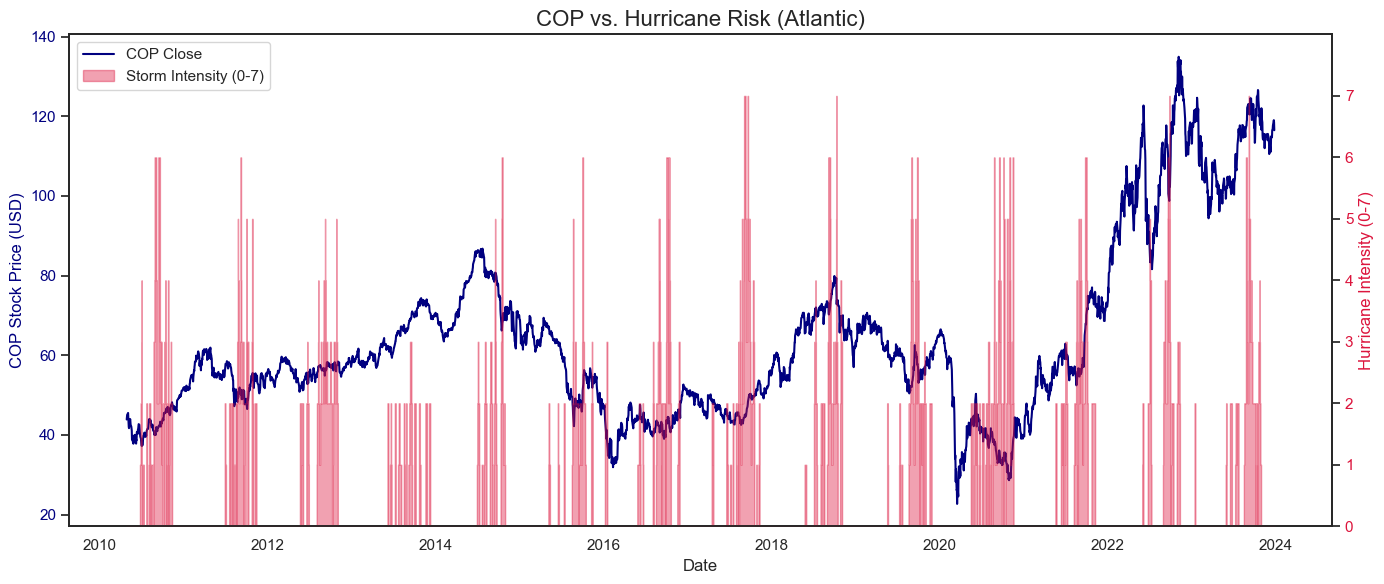

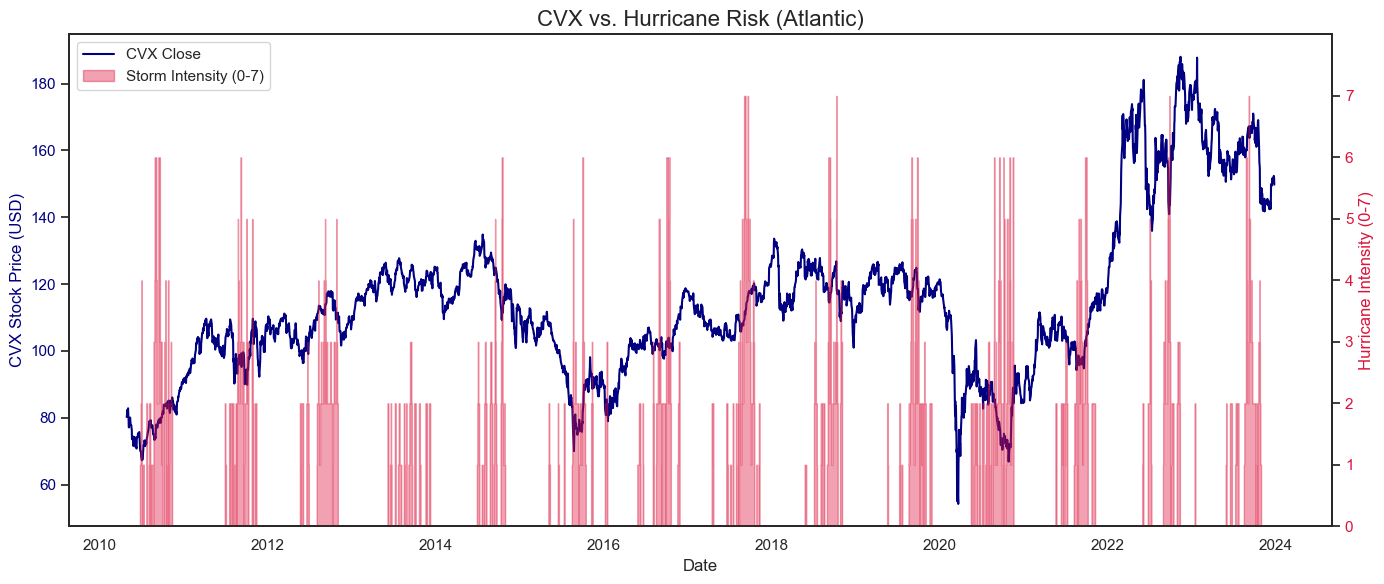

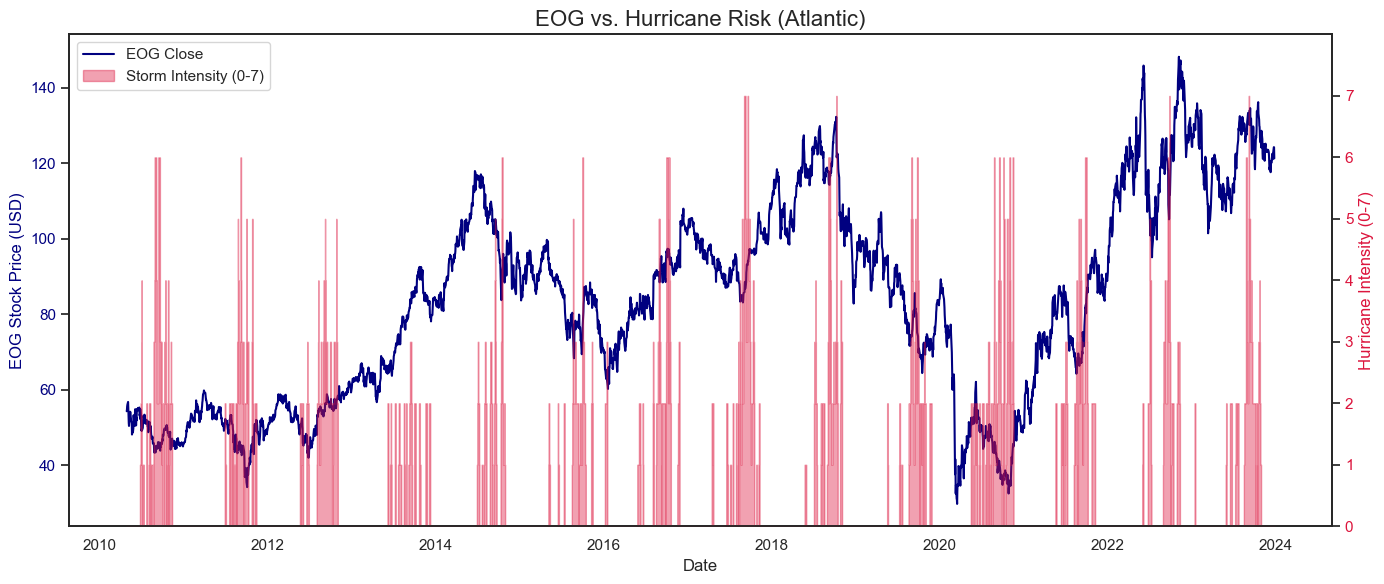

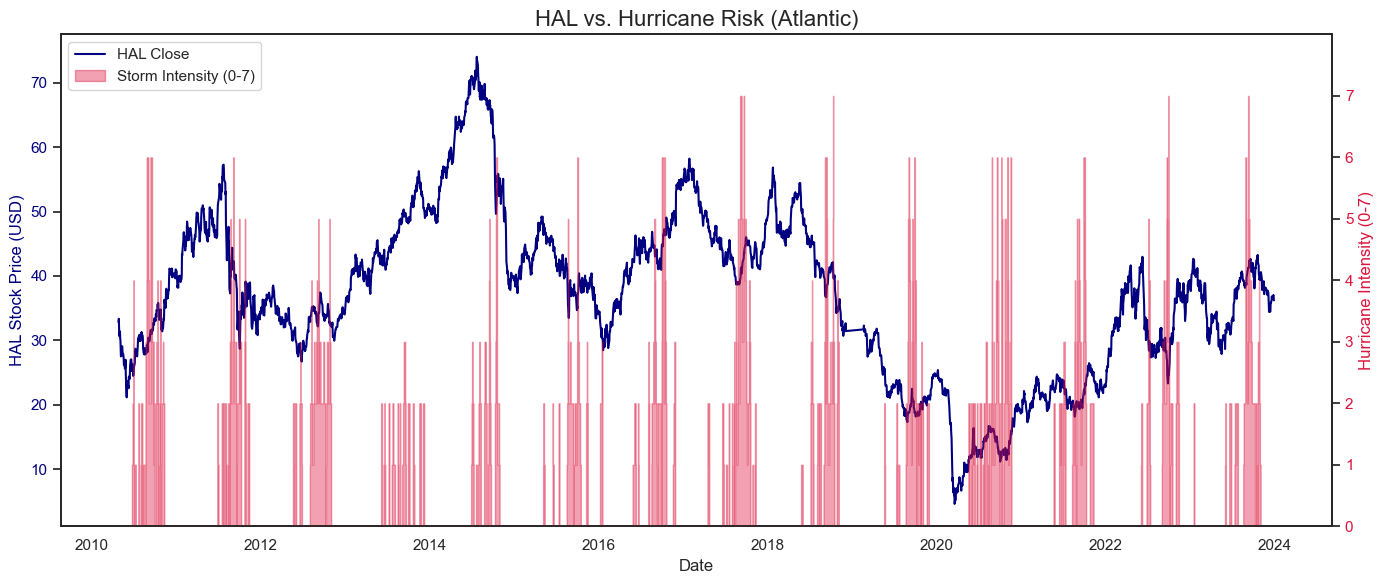

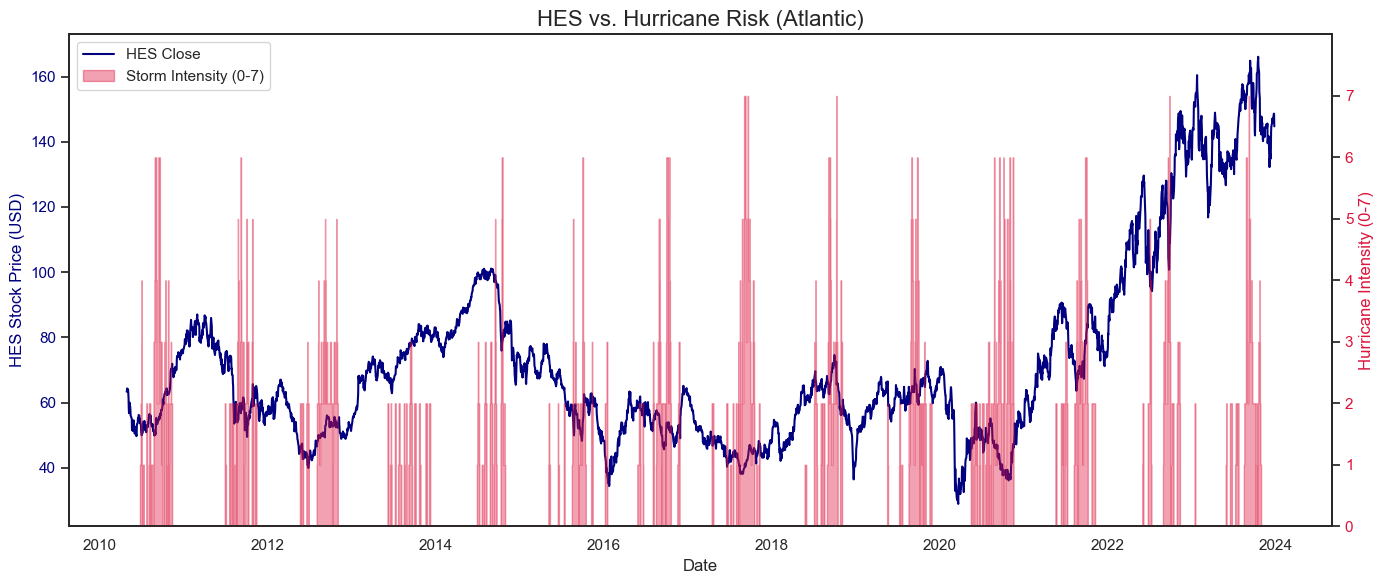

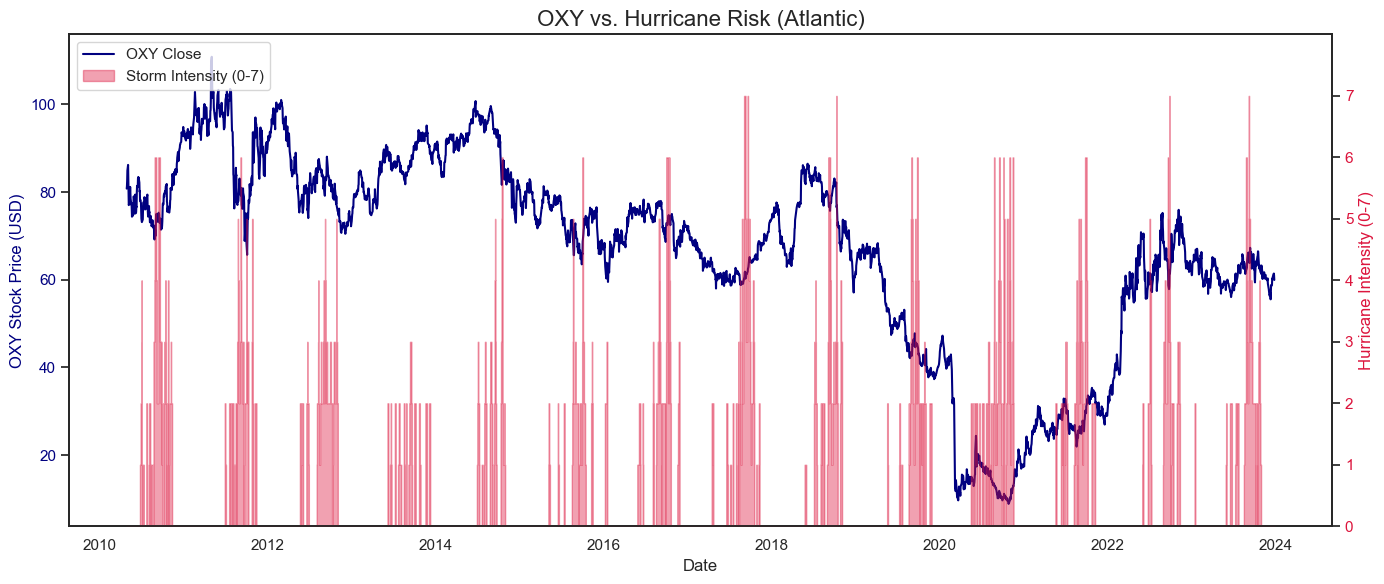

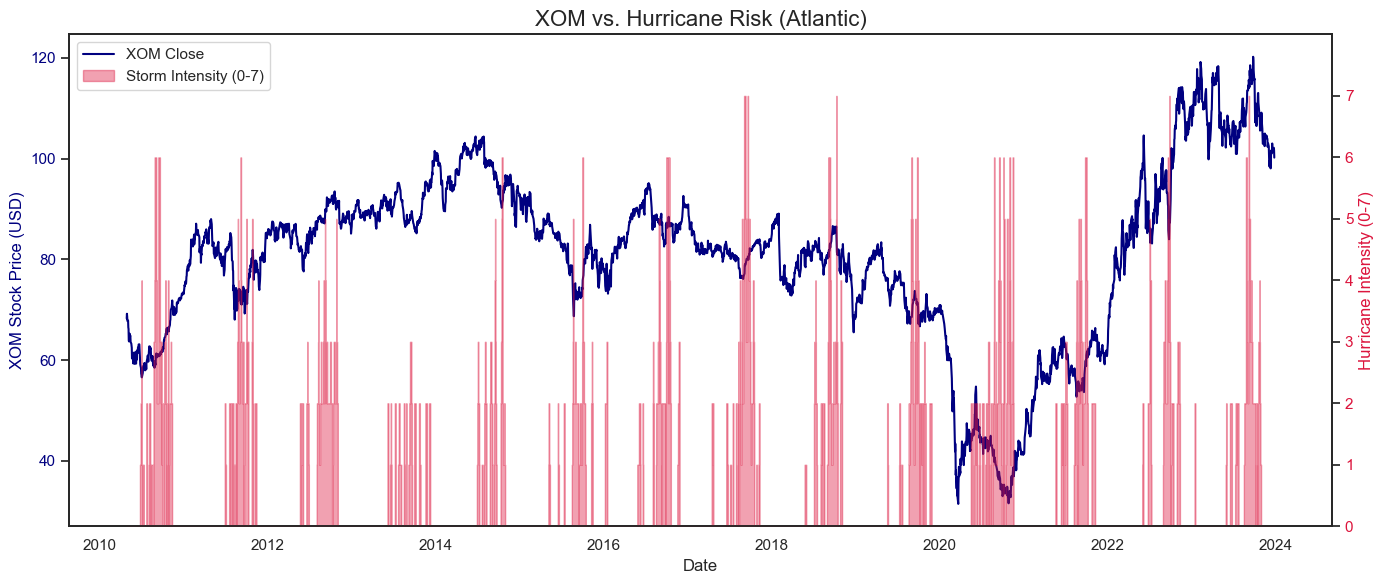

In [20]:
# Temporary merge for plotting
plot_df = pd.merge(df_skeleton, df_hurr_clean, on='date', how='left')

tickers = plot_df['ticker'].unique()
sns.set(style="white")

for t in tickers:
    subset = plot_df[plot_df['ticker'] == t]
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # 1. Stock Price (Left Axis)
    color1 = 'navy'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{t} Stock Price (USD)', color=color1, fontsize=12)
    ax1.plot(subset['date'], subset['close'], color=color1, label=f'{t} Close', linewidth=1.5)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    # 2. Hurricane Intensity (Right Axis)
    ax2 = ax1.twinx()  
    color2 = 'crimson'
    ax2.set_ylabel('Hurricane Intensity (0-7)', color=color2, fontsize=12)
    
    # Use fill_between for the "Risk Gauge" look
    ax2.fill_between(subset['date'], subset['intensity_0_7'], color=color2, alpha=0.4, step="mid", label='Storm Risk')
    ax2.set_ylim(0, 8) # Fix scale to 0-7
    ax2.set_yticks(range(0, 8)) # Explicit ticks for categories
    ax2.tick_params(axis='y', labelcolor=color2)
    
    plt.title(f"{t} vs. Hurricane Risk (Atlantic)", fontsize=16)
    
    # Combined Legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    import matplotlib.patches as mpatches
    patch = mpatches.Patch(color=color2, alpha=0.4, label='Storm Intensity (0-7)')
    ax1.legend(lines_1 + [patch], labels_1 + ['Storm Intensity (0-7)'], loc='upper left')
    
    plt.tight_layout()
    plt.show()